### Dataset Collection

In [ ]:
!pip install pytrends

In [ ]:
macro_data = {
    "Y+Q": [
        "2017Q2", "2017Q3", "2017Q4", "2018Q1", "2018Q2", "2018Q3", "2018Q4",
        "2019Q1", "2019Q2", "2019Q3", "2019Q4", "2020Q1", "2020Q2", "2020Q3", "2020Q4",
        "2021Q1", "2021Q2", "2021Q3", "2021Q4", "2022Q1", "2022Q2", "2022Q3", "2022Q4",
        "2023Q1", "2023Q2", "2023Q3", "2023Q4", "2024Q1", "2024Q2", "2024Q3", "2024Q4",
        "2025Q1", "2025Q2"
    ],
    "CPI": [131.0333333, 131.0, 130.6,
        131.5, 134.9333333, 136.9666667, 136.6,
        137.8, 140.1333333, 140.5333333, 139.9666667,
        142.0333333, 145.0, 148.7333333, 149.3,
        151.3666667, 155.0, 158.2, 156.5666667,
        159.8333333, 162.8666667, 166.1333333, 166.5,
        171.4666667, 174.3333333, 176.3, 176.8333333,
        179.4, 185.5333333, 185.7666667, 185.7,
        188.2, 193.4
        ],
    "CSI": [
        98.4, 96.4, 94.85, 95.6, 96.25, 94.8, 95.3, 104.6, 97.3, 92.55, 85.7,
        84.65, 63.7, 51.85, 52.3, 55.2, 49.8, 54.1, 63.4, 68.05, 75.9, 78.95,
        83.5, 85.9, 88.5, 90.15, 92.208, 96.8, 97.148, 94.284, 93.954, 94.641, 95.428
    ],
    "FEI": [
        122.1, 120.2, 119.75, 118.6, 119.55, 121.1, 124.45, 133.4, 128.4, 121.4, 114.5,
        115.15, 97.9, 110.65, 115.9, 113.8, 97.6, 106.3, 110.3, 109.25, 113.0, 113.15,
        114.9, 115.85, 116.3, 119.45, 120.61, 124.169, 124.812, 121.005, 121.888, 121.547, 123.374
    ],
}

In [ ]:
# Full pipeline: fixed-group Pytrends -> fiscal quarters -> segment GT -> merge with original df + macros
import pandas as pd
import time
from pytrends.request import TrendReq

# ----------------------
# 0) Original data (your provided df)
# ----------------------
data = {
    "Quarter": [
        "2018Q1", "2018Q2", "2018Q3", "2018Q4", "2019Q1", "2019Q2", "2019Q3", "2019Q4",
        "2020Q1", "2020Q2", "2020Q3", "2020Q4", "2021Q1", "2021Q2", "2021Q3", "2021Q4",
        "2022Q1", "2022Q2", "2022Q3", "2022Q4", "2023Q1", "2023Q2", "2023Q3", "2023Q4",
        "2024Q1", "2024Q2", "2024Q3", "2024Q4", "2025Q1", "2025Q2", "2025Q3", "2025Q4"
    ],
    "Personal Care": [
        4407, 4316, 4090, 4096, 4440, 4349, 4579, 4432,
        4626, 4580, 4448, 3834, 4043, 4550, 4868, 4577,
        4585, 5026, 5213, 4743, 5406, 5595, 5764, 5257,
        5668, 5873, 5782, 5125, 5667, 5832, 5799, 5391
    ],
    "Foods": [
        1785, 1704, 1572, 1735, 1783, 1703, 1728, 1916,
        1950, 1847, 1865, 1788, 2958, 3379, 3356, 3511,
        3319, 3622, 3466, 3698, 3627, 3755, 3700, 3794,
        3797, 3851, 3733, 3910, 3850, 3803, 3745, 3896
    ],
    "Home Care": [
        3146, 3080, 2741, 3102, 3146, 3079, 3147, 3502,
        3464, 3370, 3456, 3350, 3392, 3318, 3409, 3838,
        3797, 3838, 4192, 4743, 4930, 5142, 5514, 5637,
        5421, 5308, 5444, 5709, 5673, 5731, 5739, 5815
    ],
    "Others": [
        149, 134, 187, 164, 409, 359, 387, 351,
        324, 308, 334, 239, 338, 436, 548, 507,
        493, 560, 568, 583, 661, 652, 619, 527,
        610, 591, 608, 466, 517, 560, 535, 568
    ]
}
df = pd.DataFrame(data).set_index("Quarter")

# Compute YoY % change for each column
yoy_df = df.pct_change(periods=4) * 100
yoy_df = yoy_df.add_suffix(" YoY %")
final_df = pd.concat([df, yoy_df], axis=1)

# Step: Volume Index based on 2018Q1
base_quarter = "2018Q1"
for col in df.columns:
    final_df[col + " Volume Index"] = df[col] / df.loc[base_quarter, col] * 100
final_df = final_df.dropna(axis=0)

# Chained Volume Index from YoY% (same logic you had)
for col in df.columns:
    yoy_col = col + " YoY %"
    vol_chain = [100]  # base
    # iterate rows in final_df (which already aligned with df rows)
    for t in range(1, len(final_df)):
        prev = vol_chain[-1]
        yoy = final_df.iloc[t][yoy_col]
        if pd.isna(yoy):
            vol_chain.append(None)
        else:
            vol_chain.append(prev * (1 + yoy / 100))
    final_df[col + " Chain Volume Index"] = vol_chain

# ----------------------
# Macro data (your provided macro)
# ----------------------

macro_df = pd.DataFrame(macro_data).set_index("Y+Q")

# ----------------------
# Pytrends config + fixed groups (each group <= 5 keywords)
# ----------------------
pytrends = TrendReq(hl='en-US', tz=330)
country = 'IN'
start_date = '2017-01-01'
end_date = '2025-06-01'

# brands dict (key -> search term)
brands = {
    'trend_surf_excel': 'Surf Excel',
    'trend_wheel': 'Wheel detergent',
    'trend_vim': 'Vim bar',
    'trend_lifebuoy': 'Lifebuoy',
    'trend_dove': 'Dove soap',
    'trend_clinic_plus': 'Clinic Plus',
    'trend_brooke_bond': 'Brooke Bond',
    'trend_kwality_walls': "Kwality Wall's",
    'trend_kissan': 'Kissan ketchup',
    'trend_ponds': "Pond's cream",
    'trend_lakme': 'Lakme makeup',
    'trend_pureit': 'Pureit water purifier'
}

# Grouping chosen so that brands of the same segment sit in the same group
group_A = [brands[k] for k in [
    'trend_lifebuoy', 'trend_dove', 'trend_clinic_plus', 'trend_ponds', 'trend_lakme'
]]  # Personal Care (5)
group_B = [brands[k] for k in [
    'trend_surf_excel', 'trend_wheel', 'trend_vim'
]]  # Home Care (3)
group_C = [brands[k] for k in [
    'trend_brooke_bond', 'trend_kwality_walls', 'trend_kissan', 'trend_pureit'
]]  # Foods (3) + Pureit -> Others (1)

groups = [group_A, group_B, group_C]

# ----------------------
# Fetch each group (no scaling between groups)
# ----------------------
all_weekly = pd.DataFrame()
for g in groups:
    print("Fetching group:", g)
    pytrends.build_payload(g, timeframe=f'{start_date} {end_date}', geo=country)
    data = pytrends.interest_over_time().drop(columns='isPartial', errors='ignore')
    if data.empty:
        print("  -> empty result for this group, skipping")
        continue
    # join into all_weekly (outer join so all dates preserved)
    if all_weekly.empty:
        all_weekly = data
    else:
        # if there are accidental duplicate column names, remove duplicates before join
        data = data.loc[:, ~data.columns.duplicated()]
        all_weekly = all_weekly.join(data, how='outer')
    time.sleep(5)  # polite pause

# Safety: convert columns (search terms) -> trend_xxx keys for easier mapping later
search_to_key = {v: k for k, v in brands.items()}
# rename columns only if present
rename_map = {col: search_to_key[col] for col in all_weekly.columns if col in search_to_key}
all_weekly = all_weekly.rename(columns=rename_map).reset_index().rename(columns={'date':'date'})

# ----------------------
# weekly -> financial quarter mapping (Apr-Mar fiscal)
# ----------------------
def to_fy_quarter(dt):
    y, m = dt.year, dt.month
    if m >= 4:
        fy = y + 1
        q = ((m - 4) // 3) + 1
    else:
        fy = y
        q = 4
    return f"{fy}Q{q}"

all_weekly['date'] = pd.to_datetime(all_weekly['date'])
all_weekly['quarter'] = all_weekly['date'].apply(to_fy_quarter)

quarterly = all_weekly.drop(columns=['date']).groupby('quarter').mean().reset_index()

# ----------------------
# Map trend keys -> segments (Pureit -> Others)
# ----------------------
brand_to_segment = {
    'trend_surf_excel': 'Home Care',
    'trend_wheel': 'Home Care',
    'trend_vim': 'Home Care',
    'trend_brooke_bond': 'Foods',
    'trend_kwality_walls': 'Foods',
    'trend_kissan': 'Foods',
    'trend_lifebuoy': 'Personal Care',
    'trend_dove': 'Personal Care',
    'trend_clinic_plus': 'Personal Care',
    'trend_ponds': 'Personal Care',
    'trend_lakme': 'Personal Care',
    'trend_pureit': 'Others'
}

segments = sorted(set(brand_to_segment.values()))
# compute segment-level GT (averaging brands belonging to same segment)
for seg in segments:
    cols = [k for k, s in brand_to_segment.items() if s == seg and k in quarterly.columns]
    if cols:
        quarterly[f"{seg}_GT"] = quarterly[cols].mean(axis=1)
    else:
        quarterly[f"{seg}_GT"] = pd.NA

gt_segment = quarterly[['quarter'] + [f"{seg}_GT" for seg in segments]]

# ----------------------
# Keep only quarters present in your original final_df (omit extra data)
# ----------------------
original_quarters = final_df.index.tolist()  # final_df created above from your sales + YoY
gt_segment = gt_segment[gt_segment['quarter'].isin(original_quarters)].copy()

# ----------------------
# Merge GT into final_df
# ----------------------
final_out = final_df.reset_index().merge(gt_segment, left_on='Quarter', right_on='quarter', how='left') \
                      .drop(columns=['quarter']).set_index('Quarter')

# ----------------------
# Add macro data (CPI, CSI, FEI)
# ----------------------
final_out = final_out.join(macro_df, how='left')

# ----------------------
# Save result
# ----------------------
final_out.to_csv('hul_final_fixedgroups_GT_macro.csv', index=True)
print("Saved hul_final_fixedgroups_GT_macro.csv")
print("\nPreview (last 8 rows):")
pd.set_option("display.max_columns", None)

final_out=final_out.dropna()
print(final_out.tail(8))

Fetching group: ['Lifebuoy', 'Dove soap', 'Clinic Plus', "Pond's cream", 'Lakme makeup']
Fetching group: ['Surf Excel', 'Wheel detergent', 'Vim bar']
Fetching group: ['Brooke Bond', "Kwality Wall's", 'Kissan ketchup', 'Pureit water purifier']
Saved hul_final_fixedgroups_GT_macro.csv

Preview (last 8 rows):
         Personal Care  Foods  Home Care  Others  Personal Care YoY %  \
Quarter                                                                 
2023Q3            5764   3700       5514     619            10.569730   
2023Q4            5257   3794       5637     527            10.837023   
2024Q1            5668   3797       5421     610             4.846467   
2024Q2            5873   3851       5308     591             4.968722   
2024Q3            5782   3733       5444     608             0.312283   
2024Q4            5125   3910       5709     466            -2.510938   
2025Q1            5667   3850       5673     517            -0.017643   
2025Q2            5832   3803      

In [ ]:
#save file
final_out.to_csv('demand_forecast_data.csv', index=True)

### Processing

In [ ]:
# Requirements: pandas, numpy, scikit-learn
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from math import sqrt

# --- helper metrics
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # avoid division by zero: use small epsilon or mask zeros
    eps = 1e-8
    return np.mean(np.abs((y_true - y_pred) / (np.maximum(np.abs(y_true), eps)))) * 100

def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

# --- configure segments / column names (adjust if needed)
segments = ["Personal Care", "Foods", "Home Care", "Others"]  # target column names
gt_suffix = "_GT"
macro_cols = ["CPI", "CSI", "FEI"]

#read filr
df = pd.read_csv("demand_forecast_data.csv")


In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

def prepare_gt_features(gt_segment, final_df):
    # --- Ensure final_df uses "Quarter" as index ---
    if "Quarter" in final_df.columns:
        final_df = final_df.set_index("Quarter")

    # --- Ensure gt_segment uses "quarter" as index ---
    if "quarter" in gt_segment.columns:
        gt_quarters = gt_segment.set_index("quarter")
    else:
        raise KeyError("gt_segment must contain 'quarter' column")

    # --- Align quarters ---
    common_quarters = gt_quarters.index.intersection(final_df.index)
    gt_quarters = gt_quarters.loc[common_quarters]

    # --- Standardize values ---
    scaler = StandardScaler()
    gt_features = pd.DataFrame(
        scaler.fit_transform(gt_quarters),
        index=gt_quarters.index,
        columns=gt_quarters.columns
    )

    # --- Rename for clarity ---
    gt_features.columns = [col.replace("_GT", "_GoogleTrends") for col in gt_features.columns]

    return gt_features

# ✅ Usage
gt_features = prepare_gt_features(gt_segment, df)
final_df_enhanced = df.set_index("Quarter").join(gt_features, how="inner")


In [ ]:
final_df_enhanced.to_csv('final_df_gt.csv', index=True)
final_df_enhanced

Personal Care  Foods  Home Care  Others  Personal Care YoY %  \
Quarter                                                                 
2019Q1            4440   1783       3146     409             0.748809   
2019Q2            4349   1703       3079     359             0.764597   
2019Q3            4579   1728       3147     387            11.955990   
2019Q4            4432   1916       3502     351             8.203125   
2020Q1            4626   1950       3464     324             4.189189   
2020Q2            4580   1847       3370     308             5.311566   
2020Q3            4448   1865       3456     334            -2.860887   
2020Q4            3834   1788       3350     239           -13.492780   
2021Q1            4043   2958       3392     338           -12.602681   
2021Q2            4550   3379       3318     436            -0.655022   
2021Q3            4868   3356       3409     548             9.442446   
2021Q4            4577   3511       3838     507            19.379238   
2022Q1            4585   3319       3797     493            13.405887   
2022Q2            5026   3622       3838     560            10.461538   
2022Q3            5213   3466       4192     568             7.087099   
2022Q4            4743   3698       4743     583             3.626830   
2023Q1            5406   3627       4930     661            17.906216   
2023Q2            5595   3755       5142     652            11.321130   
2023Q3            5764   3700       5514     619            10.569730   
2023Q4            5257   3794       5637     527            10.837023   
2024Q1            5668   3797       5421     610             4.846467   
2024Q2            5873   3851       5308     591             4.968722   
2024Q3            5782   3733       5444     608             0.312283   
2024Q4            5125   3910       5709     466            -2.510938   
2025Q1            5667   3850       5673     517            -0.017643   
2025Q2            5832   3803       5731     560            -0.698110   

         Foods YoY %  Home Care YoY %  Others YoY %  \
Quarter                                               
2019Q1     -0.112045         0.000000    174.496644   
2019Q2     -0.058685        -0.032468    167.910448   
2019Q3      9.923664        14.812112    106.951872   
2019Q4     10.432277        12.894907    114.024390   
2020Q1      9.366237        10.108074    -20.782396   
2020Q2      8.455666         9.451120    -14.206128   
2020Q3      7.928241         9.818875    -13.695090   
2020Q4     -6.680585        -4.340377    -31.908832   
2021Q1     51.692308        -2.078522      4.320988   
2021Q2     82.945317        -1.543027     41.558442   
2021Q3     79.946381        -1.359954     64.071856   
2021Q4     96.364653        14.567164    112.133891   
2022Q1     12.204192        11.939858     45.857988   
2022Q2      7.191477        15.672092     28.440367   
2022Q3      3.277712        22.968612      3.649635   
2022Q4      5.326118        23.579990     14.990138   
2023Q1      9.279904        29.839347     34.077079   
2023Q2      3.672004        33.976029     16.428571   
2023Q3      6.751298        31.536260      8.978873   
2023Q4      2.595998        18.848830     -9.605489   
2024Q1      4.687069         9.959432     -7.715582   
2024Q2      2.556591         3.228316     -9.355828   
2024Q3      0.891892        -1.269496     -1.777060   
2024Q4      3.057459         1.277275    -11.574953   
2025Q1      1.395839         4.648589    -15.245902   
2025Q2     -1.246429         7.969103     -5.245347   

         Personal Care Volume Index  Foods Volume Index  \
Quarter                                                   
2019Q1                   100.748809           99.887955   
2019Q2                    98.683912           95.406162   
2019Q3                   103.902882           96.806723   
2019Q4                   100.567279          107.338936   
2020Q1                   104.969367          109.243697   
2020Q2    

In [ ]:
final_df_enhanced.describe()

Personal Care        Foods    Home Care      Others  \
count      26.000000    26.000000    26.000000   26.000000   
mean     4956.230769  3065.730769  4290.384615  482.884615   
std       596.933317   870.288392  1006.028194  121.308310   
min      3834.000000  1703.000000  3079.000000  239.000000   
25%      4556.750000  1924.500000  3396.250000  366.000000   
50%      4805.500000  3488.500000  3838.000000  512.000000   
75%      5547.750000  3749.500000  5392.750000  579.250000   
max      5873.000000  3910.000000  5731.000000  661.000000   

       Personal Care YoY %  Foods YoY %  Home Care YoY %  Others YoY %  \
count            26.000000    26.000000        26.000000     26.000000   
mean              4.711532    15.840175        10.633544     30.645330   
std               7.949247    28.009841        11.022865     58.044181   
min             -13.492780    -6.680585        -4.340377    -31.908832   
25%               0.064839     2.566443         0.319319     -9.543074   
50%               4.907594     6.038708         9.889154      6.649930   
75%              10.542682     9.784307        15.457097     44.783102   
max              19.379238    96.364653        33.976029    174.496644   

       Personal Care Volume Index  Foods Volume Index  Home Care Volume Index  \
count                   26.000000           26.000000               26.000000   
mean                   112.462690          171.749623              136.375862   
std                     13.545117           48.755652               31.978010   
min                     86.997958           95.406162               97.870312   
25%                    103.398003          107.815126              107.954545   
50%                    109.042432          195.434174              121.996186   
75%                    125.884956          210.056022              171.416084   
max                    133.265260          219.047619              182.167832   

       Others Volume Index  Personal Care Chain Volume Index  \
count            26.000000                         26.000000   
mean            324.083634                        186.812375   
std              81.414973                         83.397034   
min             160.402685                         97.720204   
25%             245.637584                        115.125530   
50%             343.624161                        152.362223   
75%             388.758389                        278.511288   
max             443.624161                        315.179705   

       Foods Chain Volume Index  Home Care Chain Volume Index  \
count                 26.000000                     26.000000   
mean                1329.083436                    472.556185   
std                 1024.940604                    414.802010   
min                   99.941315                     99.967532   
25%                  147.529468                    156.656906   
50%                 1652.027078                    215.750912   
75%                 2292.596456                    918.467156   
max                 2611.536145                   1226.481743   

       Others Chain Volume Index   Foods_GT  Home Care_GT  Others_GT  \
count                  26.000000  26.000000     26.000000  26.000000   
mean                 3814.930281   9.170940     14.012821  28.512821   
std                  3117.424733   2.524200      3.748162   6.437550   
min                   100.000000   5.444444      7.444444  21.333333   
25%                   726.545671   6.916667     10.944444  24.166667   
50%                  4058.366075   9.611111     15.388889  28.833333   
75%                  6673.677034  10.416667     17.000000  29.916667   
max                  9253.258568  16.222222     18.666667  52.333333   

       Personal Care_GT         CPI         CSI         FEI  \
count         26.000000   26.000000   26.000000   26.000000   
mean           8.630769  162.957692   80.406269  116.330962   
std            2.583175   17.414672   17.169894   

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

# Load and preprocess
df = pd.read_csv("final_df_gt.csv")
df.rename(columns={"Row Labels": "Quarter"}, inplace=True)
df["Quarter"] = pd.PeriodIndex(df["Quarter"], freq="Q-DEC")
df.set_index("Quarter", inplace=True)
df.dropna(subset=["CPI", "CSI", "FEI"], inplace=True)

segments = [
    "Personal Care",
    "Foods",
    "Home Care",
    "Others"
]

macro_features = ["CPI", "CSI", "FEI"]

# Create lag and delta features
for seg in segments:
    vol = f"{seg} Volume Index"
    chain = f"{seg} Chain Volume Index"
    yoy = f"{seg} YoY %"
    df[f"{vol}_lag1"] = df[vol].shift(1)
    df[f"{vol}_delta"] = df[vol] - df[vol].shift(1)
    df[f"{chain}_lag1"] = df[chain].shift(1)
    df[f"{yoy}_lag1"] = df[yoy].shift(1)

df.dropna(inplace=True)

rolling_window = 5
n = len(df)

if rolling_window >= n:
    raise ValueError(f"Rolling window {rolling_window} too big for data size {n}")

ridge_results = {}
xgb_results = {}

for seg in segments:
    vol = f"{seg} Volume Index"
    chain = f"{seg} Chain Volume Index"
    yoy = f"{seg} YoY %"

    features = [
        f"{vol}_lag1",
        f"{vol}_delta",
        f"{chain}_lag1",
        f"{yoy}_lag1"
    ] + macro_features

    y_tests = []
    y_preds_ridge = []
    y_preds_xgb = []

    # Indices for rolling forecast start from n - rolling_window up to n-1
    for i in range(n - rolling_window, n):
        train = df.iloc[:i]
        test = df.iloc[i:i+1]

        X_train = train[features]
        y_train = train[vol]
        X_test = test[features]
        y_test = test[vol]

        # Ridge
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        ridge = RidgeCV(alphas=[0.1, 1.0, 10.0])
        ridge.fit(X_train_scaled, y_train)
        y_pred_ridge = ridge.predict(X_test_scaled)

        # XGBoost
        xgb = XGBRegressor(n_estimators=50, max_depth=3, learning_rate=0.1, verbosity=0)
        xgb.fit(X_train, y_train)
        y_pred_xgb = xgb.predict(X_test)

        y_tests.append(y_test.values[0])
        y_preds_ridge.append(y_pred_ridge[0])
        y_preds_xgb.append(y_pred_xgb[0])

    ridge_results[seg] = {
    "MAE": mean_absolute_error(y_tests, y_preds_ridge),
    "RMSE": np.sqrt(mean_squared_error(y_tests, y_preds_ridge)),
    "R2": r2_score(y_tests, y_preds_ridge),
    "y_test": y_tests,
    "y_pred": y_preds_ridge
    }

    xgb_results[seg] = {
        "MAE": mean_absolute_error(y_tests, y_preds_xgb),
        "RMSE": np.sqrt(mean_squared_error(y_tests, y_preds_xgb)),
        "R2": r2_score(y_tests, y_preds_xgb),
        "y_test": y_tests,
        "y_pred": y_preds_xgb
    }

print("🔵 Ridge Results")
for k, v in ridge_results.items():
    print(f"{k}: MAE={v['MAE']:.2f}, RMSE={v['RMSE']:.2f}, R²={v['R2']:.4f}")

print("\n🟢 XGBoost Results")
for k, v in xgb_results.items():
    print(f"{k}: MAE={v['MAE']:.2f}, RMSE={v['RMSE']:.2f}, R²={v['R2']:.4f}")


🔵 Ridge Results
Personal Care: MAE=0.28, RMSE=0.37, R²=0.9965
Foods: MAE=1.74, RMSE=1.86, R²=0.6812
Home Care: MAE=1.51, RMSE=1.77, R²=0.8895
Others: MAE=3.89, RMSE=4.74, R²=0.9812

🟢 XGBoost Results
Personal Care: MAE=5.13, RMSE=5.87, R²=0.1100
Foods: MAE=4.84, RMSE=5.08, R²=-1.3644
Home Care: MAE=5.74, RMSE=6.23, R²=-0.3674
Others: MAE=29.79, RMSE=32.79, R²=0.1009


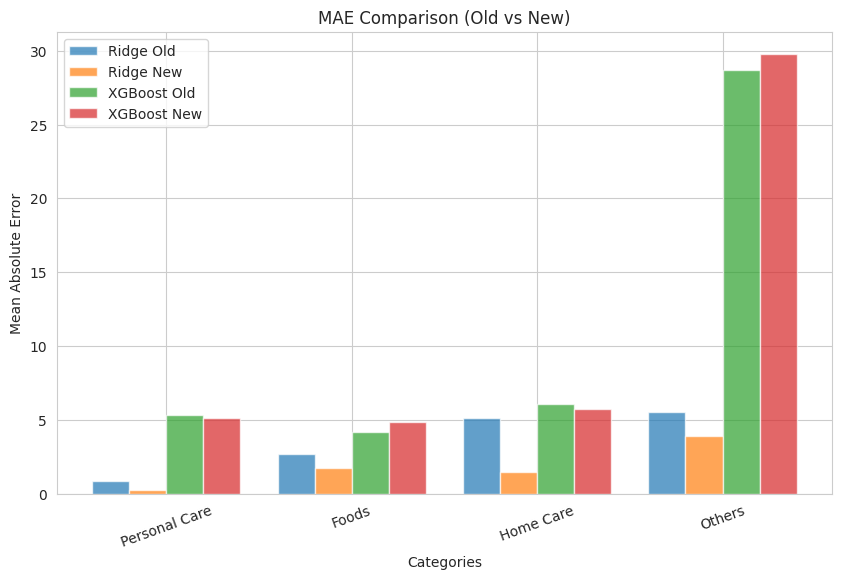

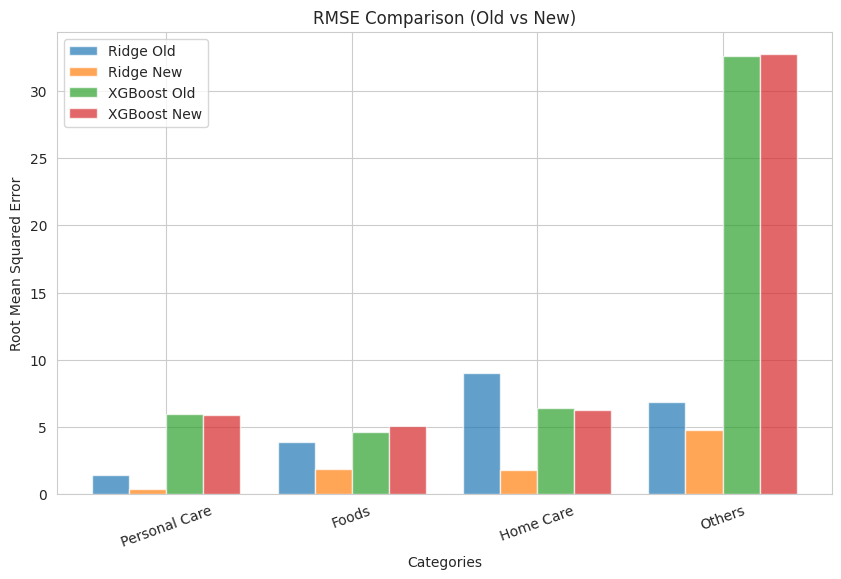

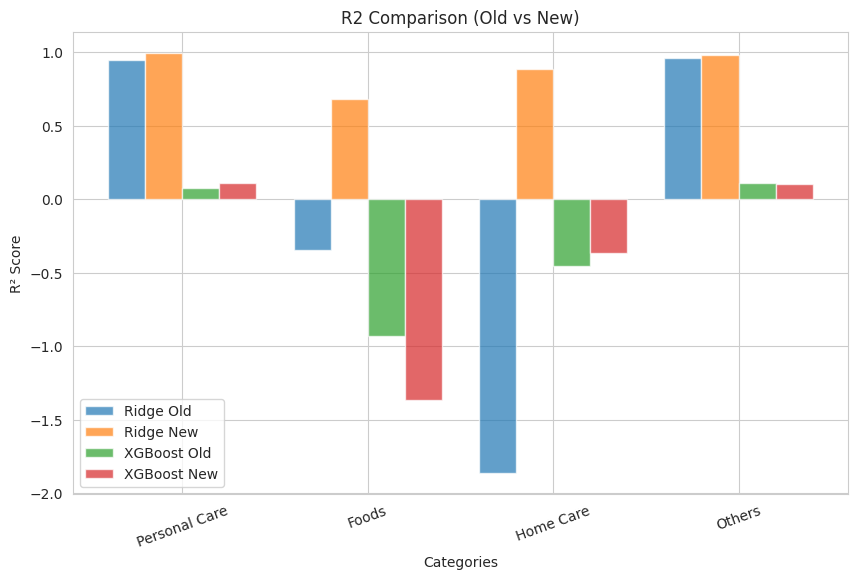

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Categories
categories = ["Personal Care", "Foods", "Home Care", "Others"]

# Old results
ridge_old = {
    "MAE": [0.87, 2.71, 5.11, 5.56],
    "RMSE": [1.40, 3.83, 9.01, 6.84],
    "R2": [0.9496, -0.3430, -1.8614, 0.9609]
}
xgb_old = {
    "MAE": [5.31, 4.16, 6.09, 28.69],
    "RMSE": [5.98, 4.59, 6.42, 32.66],
    "R2": [0.0766, -0.9286, -0.4530, 0.1079]
}

# New results
ridge_new = {
    "MAE": [0.28, 1.74, 1.51, 3.89],
    "RMSE": [0.37, 1.86, 1.77, 4.74],
    "R2": [0.9965, 0.6812, 0.8895, 0.9812]
}
xgb_new = {
    "MAE": [5.13, 4.84, 5.74, 29.79],
    "RMSE": [5.87, 5.08, 6.23, 32.79],
    "R2": [0.1100, -1.3644, -0.3674, 0.1009]
}

# Plot function
def plot_metric(metric, ylabel):
    x = np.arange(len(categories))  # x-axis positions
    width = 0.2

    fig, ax = plt.subplots(figsize=(10,6))

    # Bars
    ax.bar(x - 1.5*width, ridge_old[metric], width, label="Ridge Old", alpha=0.7)
    ax.bar(x - 0.5*width, ridge_new[metric], width, label="Ridge New", alpha=0.7)
    ax.bar(x + 0.5*width, xgb_old[metric], width, label="XGBoost Old", alpha=0.7)
    ax.bar(x + 1.5*width, xgb_new[metric], width, label="XGBoost New", alpha=0.7)

    # Labels
    ax.set_xlabel("Categories")
    ax.set_ylabel(ylabel)
    ax.set_title(f"{metric} Comparison (Old vs New)")
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=20)
    ax.legend()

    plt.show()

# Plot all three metrics
plot_metric("MAE", "Mean Absolute Error")
plot_metric("RMSE", "Root Mean Squared Error")
plot_metric("R2", "R² Score")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

# 1. Load enhanced data with Google Trends
df = pd.read_csv("final_df_gt.csv")
df.rename(columns={"Row Labels": "Quarter"}, inplace=True)
df["Quarter"] = pd.PeriodIndex(df["Quarter"], freq="Q-DEC")
df.set_index("Quarter", inplace=True)
df.dropna(subset=["CPI", "CSI", "FEI"], inplace=True)

segments = ["Personal Care", "Foods", "Home Care", "Others"]
macro_features = ["CPI", "CSI", "FEI"]

# 2. Prepare Google Trends lag feature for each segment
for seg in segments:
    gt_col = f"{seg}_GoogleTrends"      # assume you have these columns
    df[f"{gt_col}_lag1"] = df[gt_col].shift(1)

# 3. Create lag and delta features for volume, chain index, YoY
for seg in segments:
    vol = f"{seg} Volume Index"
    chain = f"{seg} Chain Volume Index"
    yoy = f"{seg} YoY %"
    df[f"{vol}_lag1"]   = df[vol].shift(1)
    df[f"{vol}_delta"]  = df[vol] - df[vol].shift(1)
    df[f"{chain}_lag1"] = df[chain].shift(1)
    df[f"{yoy}_lag1"]   = df[yoy].shift(1)

# 4. Drop rows with any NaNs (ensures all lagged features exist)
df.dropna(inplace=True)

# 5. Rolling-window evaluation with variable window sizes
rolling_windows = [3, 5, 7, 9]
results = {}

for window in rolling_windows:
    print(f"\n=== Rolling Window: {window} Quarters ===")
    for seg in segments:
        vol = f"{seg} Volume Index"
        chain = f"{seg} Chain Volume Index"
        yoy   = f"{seg} YoY %"
        gt_lag = f"{seg}_GoogleTrends_lag1"

        # Define features including GT lag
        features = [
            f"{vol}_lag1",
            f"{vol}_delta",
            f"{chain}_lag1",
            f"{yoy}_lag1",
            gt_lag
        ] + macro_features

        df_seg = df[features + [vol]].copy()
        n = len(df_seg)
        y_true, y_pred_ridge, y_pred_xgb = [], [], []

        for i in range(n - window):
            train = df_seg.iloc[: i + window]
            test  = df_seg.iloc[i + window : i + window + 1]

            X_train = train[features]
            y_train = train[vol]
            X_test  = test[features]
            y_test  = test[vol].values[0]

            # Ridge
            scaler = StandardScaler()
            X_tr_s = scaler.fit_transform(X_train)
            X_te_s = scaler.transform(X_test)
            ridge = RidgeCV(alphas=[0.1, 1.0, 10.0])
            ridge.fit(X_tr_s, y_train)
            y_pred_ridge.append(ridge.predict(X_te_s)[0])

            # XGBoost
            xgb = XGBRegressor(n_estimators=50, max_depth=3, learning_rate=0.1, verbosity=0)
            xgb.fit(X_train, y_train)
            y_pred_xgb.append(xgb.predict(X_test)[0])

            y_true.append(y_test)

        # Compute and print metrics
        mae_r = mean_absolute_error(y_true, y_pred_ridge)
        rmse_r = np.sqrt(mean_squared_error(y_true, y_pred_ridge))
        r2_r   = r2_score(y_true, y_pred_ridge)
        print(f"{seg} Ridge -> MAE={mae_r:.2f}, RMSE={rmse_r:.2f}, R²={r2_r:.4f}")

        mae_x = mean_absolute_error(y_true, y_pred_xgb)
        rmse_x = np.sqrt(mean_squared_error(y_true, y_pred_xgb))
        r2_x   = r2_score(y_true, y_pred_xgb)
        print(f"{seg} XGB   -> MAE={mae_x:.2f}, RMSE={rmse_x:.2f}, R²={r2_x:.4f}")

    print("-" * 40)



=== Rolling Window: 3 Quarters ===
Personal Care Ridge -> MAE=2.94, RMSE=7.62, R²=0.6767
Personal Care XGB   -> MAE=6.33, RMSE=7.58, R²=0.6801
Foods Ridge -> MAE=10.30, RMSE=19.54, R²=0.7593
Foods XGB   -> MAE=16.29, RMSE=29.39, R²=0.4557
Home Care Ridge -> MAE=2.87, RMSE=5.94, R²=0.9612
Home Care XGB   -> MAE=6.64, RMSE=8.44, R²=0.9215
Others Ridge -> MAE=9.91, RMSE=15.83, R²=0.9608
Others XGB   -> MAE=36.09, RMSE=48.35, R²=0.6344
----------------------------------------

=== Rolling Window: 5 Quarters ===
Personal Care Ridge -> MAE=2.73, RMSE=7.77, R²=0.6757
Personal Care XGB   -> MAE=6.74, RMSE=7.91, R²=0.6641
Foods Ridge -> MAE=10.56, RMSE=20.34, R²=0.6124
Foods XGB   -> MAE=16.86, RMSE=30.63, R²=0.1212
Home Care Ridge -> MAE=1.52, RMSE=1.90, R²=0.9959
Home Care XGB   -> MAE=7.09, RMSE=8.81, R²=0.9108
Others Ridge -> MAE=8.80, RMSE=14.22, R²=0.9619
Others XGB   -> MAE=37.02, RMSE=49.79, R²=0.5333
----------------------------------------

=== Rolling Window: 7 Quarters ===
Personal

Saved metrics to rolling_metrics_summary.csv


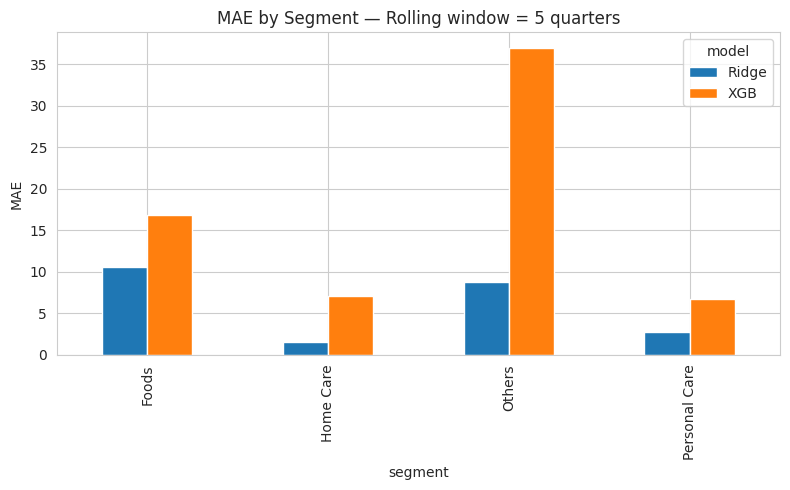

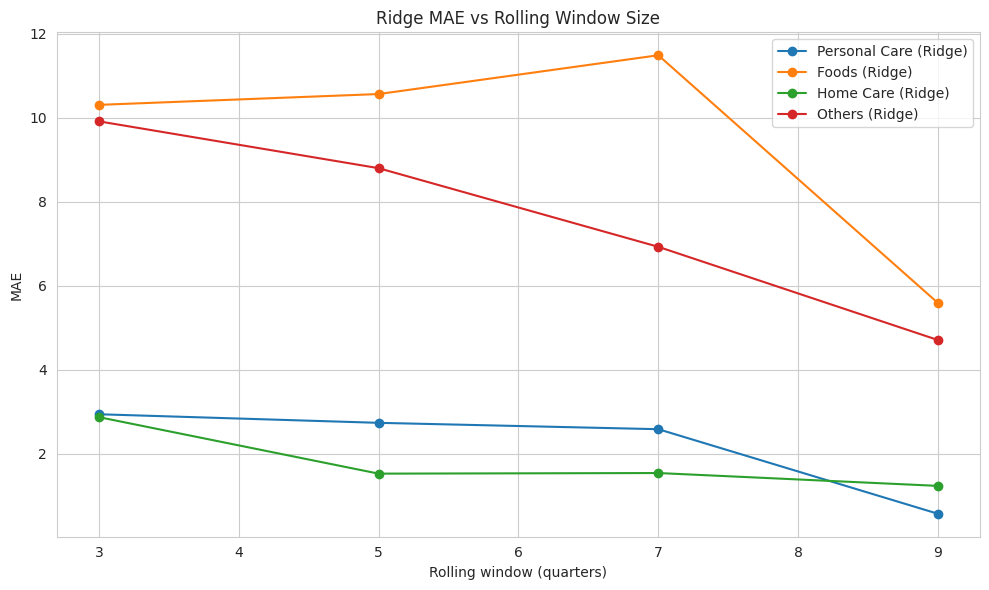

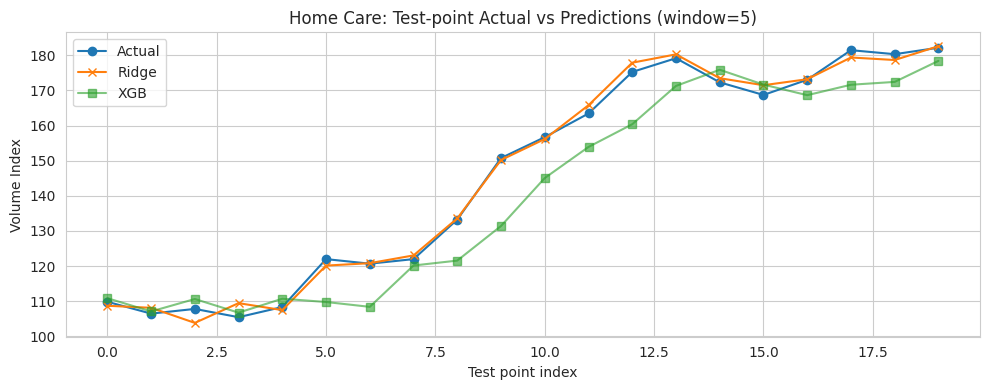

In [ ]:
# Run this cell to collect metrics and produce the three plots + summary tables
import pandas as pd
import numpy as np
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# --- load & feature prep (same as yours) ---
df = pd.read_csv("final_df_gt.csv")
if "Row Labels" in df.columns:
    df.rename(columns={"Row Labels": "Quarter"}, inplace=True)
df["Quarter"] = pd.PeriodIndex(df["Quarter"], freq="Q-DEC")
df.set_index("Quarter", inplace=True)
df.dropna(subset=["CPI", "CSI", "FEI"], inplace=True)

segments = ["Personal Care", "Foods", "Home Care", "Others"]
macro_features = ["CPI", "CSI", "FEI"]

for seg in segments:
    gt_col = f"{seg}_GoogleTrends"
    if gt_col in df.columns:
        df[f"{gt_col}_lag1"] = df[gt_col].shift(1)
    vol = f"{seg} Volume Index"
    chain = f"{seg} Chain Volume Index"
    yoy = f"{seg} YoY %"
    df[f"{vol}_lag1"]   = df[vol].shift(1)
    df[f"{vol}_delta"]  = df[vol] - df[vol].shift(1)
    df[f"{chain}_lag1"] = df[chain].shift(1)
    df[f"{yoy}_lag1"]   = df[yoy].shift(1)

df.dropna(inplace=True)

# --- rolling evaluation: capture metrics and predictions ---
rolling_windows = [3,5,7,9]
records = []   # metrics
pred_store = []  # store predictions for plotting (window, seg, y_true, y_ridge, y_xgb)

for window in rolling_windows:
    for seg in segments:
        vol = f"{seg} Volume Index"
        chain = f"{seg} Chain Volume Index"
        yoy   = f"{seg} YoY %"
        gt_lag = f"{seg}_GoogleTrends_lag1"
        features = [f"{vol}_lag1", f"{vol}_delta", f"{chain}_lag1", f"{yoy}_lag1"]
        if gt_lag in df.columns:
            features.append(gt_lag)
        features += [c for c in macro_features if c in df.columns]
        df_seg = df[features + [vol]].copy()
        n = len(df_seg)
        y_true_all, y_ridge_all, y_xgb_all = [], [], []

        for i in range(n - window):
            train = df_seg.iloc[: i + window]
            test  = df_seg.iloc[i + window : i + window + 1]
            X_train = train[features]; y_train = train[vol]
            X_test  = test[features]; y_test  = test[vol].values[0]
            # Ridge
            scaler = StandardScaler()
            X_tr_s = scaler.fit_transform(X_train)
            X_te_s = scaler.transform(X_test)
            ridge = RidgeCV(alphas=[0.1, 1.0, 10.0])
            ridge.fit(X_tr_s, y_train)
            y_r = ridge.predict(X_te_s)[0]
            # XGB
            xgb = XGBRegressor(n_estimators=50, max_depth=3, learning_rate=0.1, verbosity=0)
            xgb.fit(X_train, y_train)
            y_x = xgb.predict(X_test)[0]

            y_true_all.append(y_test); y_ridge_all.append(y_r); y_xgb_all.append(y_x)

        # metrics
        if len(y_true_all) > 0:
            for model_name, preds in [("Ridge", y_ridge_all), ("XGB", y_xgb_all)]:
                mae = mean_absolute_error(y_true_all, preds)
                rmse = np.sqrt(mean_squared_error(y_true_all, preds))
                r2 = r2_score(y_true_all, preds)
                records.append({
                    "window": window,
                    "segment": seg,
                    "model": model_name,
                    "MAE": mae,
                    "RMSE": rmse,
                    "R2": r2,
                    "n_test": len(y_true_all)
                })
            pred_store.append({
                "window": window, "segment": seg,
                "y_true": np.array(y_true_all),
                "y_ridge": np.array(y_ridge_all),
                "y_xgb": np.array(y_xgb_all)
            })

metrics_df = pd.DataFrame(records)
metrics_df.to_csv("rolling_metrics_summary.csv", index=False)
print("Saved metrics to rolling_metrics_summary.csv")

# --- Plot 1: MAE bar chart for window=5 (Ridge vs XGB) ---
w = 5
df_w = metrics_df[(metrics_df.window==w) & (metrics_df.model.isin(["Ridge","XGB"]))]
pivot = df_w.pivot(index="segment", columns="model", values="MAE")
pivot.plot(kind="bar", figsize=(8,5))
plt.title(f"MAE by Segment — Rolling window = {w} quarters")
plt.ylabel("MAE")
plt.tight_layout()
plt.savefig("plot_mae_bar_window5.png", dpi=150)
plt.show()

# --- Plot 2: MAE vs window size (line) for each model and segment ---
plt.figure(figsize=(10,6))
for seg in segments:
    df_seg = metrics_df[(metrics_df.segment==seg) & (metrics_df.model=="Ridge")]
    plt.plot(df_seg.window, df_seg.MAE, marker='o', label=f"{seg} (Ridge)")
plt.title("Ridge MAE vs Rolling Window Size")
plt.xlabel("Rolling window (quarters)")
plt.ylabel("MAE")
plt.legend()
plt.tight_layout()
plt.savefig("plot_mae_vs_window_ridge.png", dpi=150)
plt.show()

# --- Plot 3: Predictions vs Actual (choose window=5) for one representative segment (Home Care recommended) ---
seg_choice = "Home Care"
ps = [p for p in pred_store if p["window"]==5 and p["segment"]==seg_choice]
if len(ps)==1:
    p = ps[0]
    idx = np.arange(len(p["y_true"]))
    plt.figure(figsize=(10,4))
    plt.plot(idx, p["y_true"], marker='o', label='Actual')
    plt.plot(idx, p["y_ridge"], marker='x', label='Ridge')
    plt.plot(idx, p["y_xgb"], marker='s', label='XGB', alpha=0.6)
    plt.title(f"{seg_choice}: Test-point Actual vs Predictions (window=5)")
    plt.xlabel("Test point index")
    plt.ylabel("Volume Index")
    plt.legend()
    plt.tight_layout()
    plt.savefig("plot_pred_vs_actual_homecare_w5.png", dpi=150)
    plt.show()
else:
    print(f"No preds found for {seg_choice} @ window=5. Choose a segment/window that exists in pred_store.")


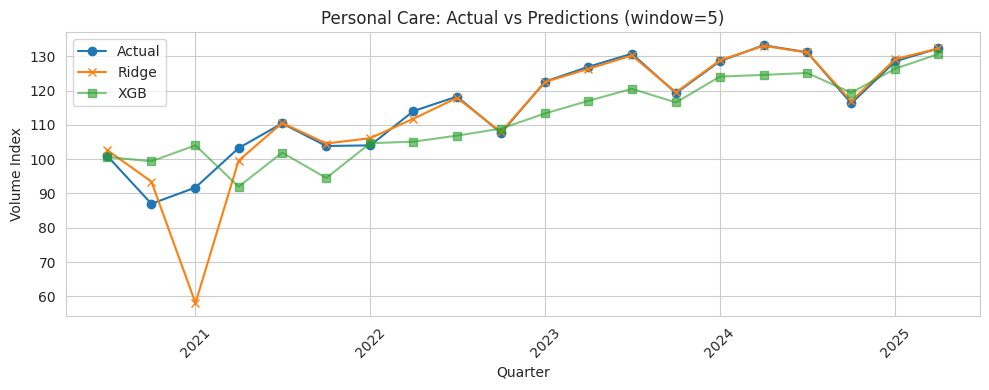

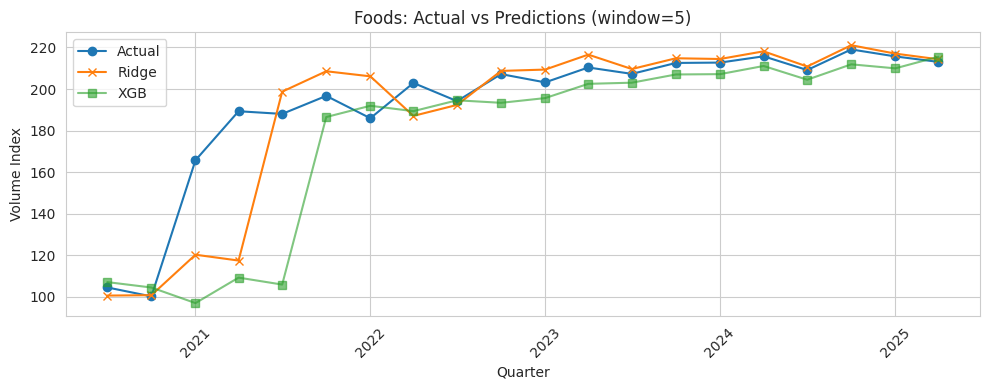

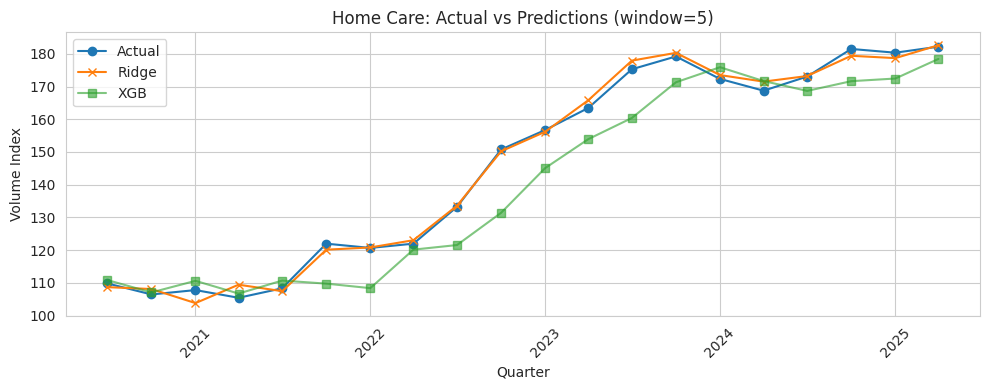

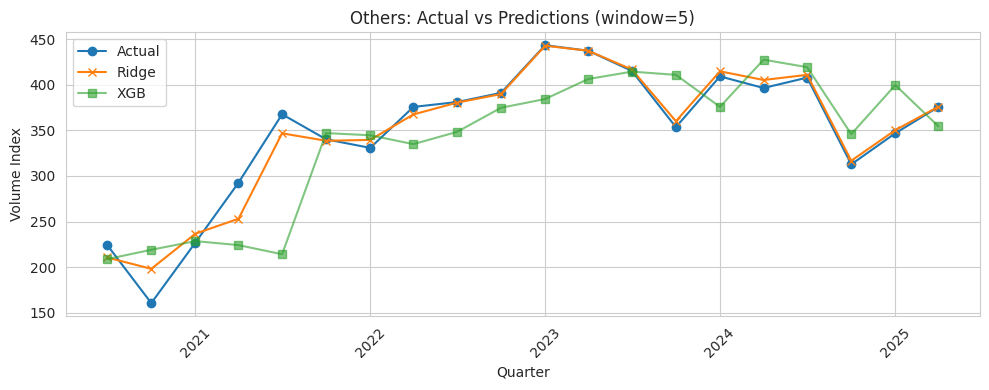

In [ ]:
import matplotlib.dates as mdates

window_choice = 5

for seg_choice in segments:
    ps = [p for p in pred_store if p["window"]==window_choice and p["segment"]==seg_choice]
    if len(ps)==1:
        p = ps[0]

        # Build corresponding dates for test points
        df_seg = df[[f"{seg_choice} Volume Index"]].dropna()
        n = len(df_seg)
        test_quarters = df_seg.index[window_choice:]  # PeriodIndex
        test_quarters = test_quarters.to_timestamp()  # convert to datetime

        if len(test_quarters) != len(p["y_true"]):
            print(f"⚠ Length mismatch for {seg_choice}, skipping")
            continue

        # Plot
        plt.figure(figsize=(10,4))
        plt.plot(test_quarters, p["y_true"], marker='o', label='Actual')
        plt.plot(test_quarters, p["y_ridge"], marker='x', label='Ridge')
        plt.plot(test_quarters, p["y_xgb"], marker='s', label='XGB', alpha=0.6)

        plt.title(f"{seg_choice}: Actual vs Predictions (window={window_choice})")
        plt.xlabel("Quarter")
        plt.ylabel("Volume Index")
        plt.legend()

        # Format x-axis: yearly ticks
        plt.gca().xaxis.set_major_locator(mdates.YearLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # year-quarter

        plt.xticks(rotation=45)
        plt.tight_layout()

        fname = f"plot_pred_vs_actual_{seg_choice.lower().replace(' ','')}_w{window_choice}.png"
        plt.savefig(fname, dpi=150)
        plt.show()
    else:
        print(f"No preds found for {seg_choice} @ window={window_choice}")


### additional experimenting

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# persistence
y_true = []
y_pred_persist = []
for i in range(1, len(df)):
    y_true.append(df.iloc[i]['Personal Care Volume Index'])      # example for Personal Care
    y_pred_persist.append(df.iloc[i-1]['Personal Care Volume Index'])
print("Persistence MAE:", mean_absolute_error(y_true, y_pred_persist))
print("Persistence RMSE:", (mean_squared_error(y_true, y_pred_persist))**0.5)


Persistence MAE: 6.989826790711736
Persistence RMSE: 8.257627025031743


In [ ]:
coef = pd.Series(ridge.coef_, index=features)
print(coef.sort_values(key=abs, ascending=False))


Others Volume Index_lag1          79.529137
Others Volume Index_delta         42.555033
Others Chain Volume Index_lag1     2.082827
CPI                                1.563210
Others YoY %_lag1                  1.454660
FEI                               -0.620224
CSI                               -0.542843
Others_GoogleTrends_lag1           0.139946
dtype: float64


In [ ]:
import xgboost as xgb_pkg
print("xgboost version:", xgb_pkg.__version__)


xgboost version: 3.0.4


In [ ]:
# Full patched pipeline: Ridge + HistGradientBoostingRegressor + GT ablation + diagnostics
# Drop this into Colab and run (expects "final_df_gt.csv" in working dir).

import pandas as pd
import numpy as np
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.ensemble import HistGradientBoostingRegressor
import warnings
warnings.filterwarnings("ignore")

# ---------- Load & basic setup ----------
df = pd.read_csv("final_df_gt.csv")
# If your csv uses "Row Labels" rename, uncomment next line:
# df.rename(columns={"Row Labels": "Quarter"}, inplace=True)
# Ensure Quarter is PeriodIndex quarterly (Q-DEC)
if "Quarter" not in df.columns and "quarter" in df.columns:
    df.rename(columns={"quarter": "Quarter"}, inplace=True)

df["Quarter"] = pd.PeriodIndex(df["Quarter"], freq="Q-DEC")
df.set_index("Quarter", inplace=True)
df = df.sort_index()

# drop rows missing essential macros
df.dropna(subset=["CPI", "CSI", "FEI"], inplace=True)

# ---------- Feature engineering (do this BEFORE CV) ----------
segments = ["Personal Care", "Foods", "Home Care", "Others"]
macro_features = ["CPI", "CSI", "FEI"]

# Create lag/delta features + GoogleTrends smoothing/lag variants + quarter cyclical features
for seg in segments:
    vol = f"{seg} Volume Index"
    chain = f"{seg} Chain Volume Index"
    yoy = f"{seg} YoY %"

    # lags & delta (these will create NaNs which we'll drop before modeling)
    df[f"{vol}_lag1"] = df[vol].shift(1)
    df[f"{vol}_delta"] = df[vol] - df[vol].shift(1)
    df[f"{chain}_lag1"] = df[chain].shift(1)
    df[f"{yoy}_lag1"] = df[yoy].shift(1)

    # GoogleTrends naming: detect common variants
    gt_candidates = [
        f"{seg}_GoogleTrends",
        f"{seg}_GT",
        f"{seg} GoogleTrends",
        f"{seg} GT",
        f"{seg.replace(' ', '')}_GoogleTrends",
    ]
    gt_col = None
    for c in gt_candidates:
        if c in df.columns:
            gt_col = c
            break

    if gt_col is not None:
        # create 3-quarter rolling mean (smoothed) then lag those features
        df[f"{seg}_GT_rm3"] = df[gt_col].rolling(window=3, min_periods=1).mean()
        df[f"{seg}_GT_lag1"] = df[gt_col].shift(1)
        df[f"{seg}_GT_rm3_lag1"] = df[f"{seg}_GT_rm3"].shift(1)

# cyclical quarter features (seasonality)
df['q'] = df.index.quarter.astype(int)
df['q_sin'] = np.sin(2*np.pi*(df['q']-1)/4)
df['q_cos'] = np.cos(2*np.pi*(df['q']-1)/4)

# Make a modeling copy and drop rows with NaNs from lags
df_model = df.copy().dropna()

# ---------- Helpers ----------
def metrics(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred)
    }

def fit_histgb(X_train, y_train, max_iter=200, learning_rate=0.05, max_depth=3, random_state=0):
    """Fit a HistGradientBoostingRegressor with early stopping enabled (sklearn native)."""
    # Use early stopping to avoid overfitting; validation_fraction used internally.
    gb = HistGradientBoostingRegressor(
        max_iter=max_iter,
        learning_rate=learning_rate,
        max_depth=max_depth,
        random_state=random_state,
        early_stopping=True,
        n_iter_no_change=20,
        validation_fraction=0.1
    )
    gb.fit(X_train, y_train)
    return gb

# ---------- CV runner (expanding-window via TimeSeriesSplit) ----------
def run_expanding_cv(df_model, seg, features, n_splits=5):
    """Expanding-window CV using TimeSeriesSplit (train on earlier, test on later).
       Returns per-fold true/preds and fold index list.
    """
    vol = f"{seg} Volume Index"
    X = df_model[features]
    y = df_model[vol]
    # Ensure we have at least 2 splits
    n_splits = max(2, min(n_splits, len(df_model)-3))
    tscv = TimeSeriesSplit(n_splits=n_splits)
    results = {"y_true": [], "ridge_pred": [], "hgb_pred": [], "persist_pred": [], "fold_idx": []}

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

        # persistence baseline: last observed value in training for each test row
        last_obs = y_train.iloc[-1]
        persist_preds = np.repeat(last_obs, len(test_idx))

        # Ridge pipeline (scaler + ridge)
        ridge_pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("ridge", RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0], cv=3))
        ])
        ridge_pipe.fit(X_train, y_train)
        ridge_preds = ridge_pipe.predict(X_test)

        # HistGradientBoosting (tree-based)
        # If training size is very small, HGB might warn; it's okay — results will still compute
        try:
            hgb = fit_histgb(X_train, y_train, max_iter=200, learning_rate=0.05, max_depth=3)
            hgb_preds = hgb.predict(X_test)
        except Exception as e:
            # Fallback: plain fit without early stopping in rare cases
            hgb = HistGradientBoostingRegressor(max_iter=200, learning_rate=0.05, max_depth=3, random_state=0)
            hgb.fit(X_train, y_train)
            hgb_preds = hgb.predict(X_test)

        # collect
        results["y_true"].extend(y_test.tolist())
        results["ridge_pred"].extend(ridge_preds.tolist())
        results["hgb_pred"].extend(hgb_preds.tolist())
        results["persist_pred"].extend(persist_preds.tolist())
        results["fold_idx"].extend([fold]*len(test_idx))

    return results

# ---------- Evaluate per-segment with/without GT (ablation) ----------
def evaluate_segment(seg, include_gt=True, n_splits=5):
    vol = f"{seg} Volume Index"
    chain = f"{seg} Chain Volume Index"
    yoy = f"{seg} YoY %"

    base_feats = [
        f"{vol}_lag1",
        f"{vol}_delta",
        f"{chain}_lag1",
        f"{yoy}_lag1"
    ] + macro_features + ['q_sin', 'q_cos']

    gt_feats = []
    # detect gt features we created earlier
    if f"{seg}_GT_lag1" in df_model.columns:
        gt_feats.append(f"{seg}_GT_lag1")
    if f"{seg}_GT_rm3_lag1" in df_model.columns:
        gt_feats.append(f"{seg}_GT_rm3_lag1")

    features = base_feats + (gt_feats if include_gt else [])
    # keep only features that exist
    features = [f for f in features if f in df_model.columns]

    if len(features) < 3:
        raise ValueError(f"Not enough features for segment {seg}: {features}")

    raw = run_expanding_cv(df_model, seg, features, n_splits=n_splits)
    ridge_m = metrics(raw["y_true"], raw["ridge_pred"])
    hgb_m = metrics(raw["y_true"], raw["hgb_pred"])
    persist_m = metrics(raw["y_true"], raw["persist_pred"])

    return {"features": features, "ridge": ridge_m, "hgb": hgb_m, "persistence": persist_m, "raw": raw}

# ---------- Run evaluation for all segments (with & without GT) ----------
summary = {}
for seg in segments:
    # number of splits chosen to be min(5, len(df_model)-3)
    n_splits = max(2, min(5, len(df_model)-3))
    out_with = evaluate_segment(seg, include_gt=True, n_splits=n_splits)
    out_no = evaluate_segment(seg, include_gt=False, n_splits=n_splits)
    summary[seg] = {"with_gt": out_with, "without_gt": out_no}

# ---------- Build summary table ----------
rows = []
for seg in segments:
    w = summary[seg]["with_gt"]
    n = summary[seg]["without_gt"]
    rows.append({
        "segment": seg,
        "ridge_MAE_withGT": w["ridge"]["MAE"],
        "ridge_MAE_noGT": n["ridge"]["MAE"],
        "ridge_RMSE_withGT": w["ridge"]["RMSE"],
        "ridge_R2_withGT": w["ridge"]["R2"],
        "hgb_MAE_withGT": w["hgb"]["MAE"],
        "persist_MAE": w["persistence"]["MAE"],
        "n_test_points": len(w["raw"]["y_true"])
    })
summary_df = pd.DataFrame(rows).set_index("segment")
print("=== Summary (metrics averaged across folds used in TimeSeriesSplit) ===")
display(summary_df)

# ---------- Diagnostics for one segment (example) ----------
seg = "Others"   # pick any segment you want to inspect further
info = summary[seg]["with_gt"]
features = info["features"]
raw = info["raw"]

print(f"\nSegment diagnostics for: {seg}")
print("Features used:", features)
print("Number of test points (total across folds):", len(raw["y_true"]))
print("Ridge metrics:", info["ridge"])
print("HistGB metrics:", info["hgb"])
print("Persistence metrics:", info["persistence"])

# Fit final Ridge pipeline on all available data for diagnostics (coefficients)
X_all = df_model[features]
y_all = df_model[f"{seg} Volume Index"]
ridge_pipe = Pipeline([("scaler", StandardScaler()), ("ridge", RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0], cv=3))])
ridge_pipe.fit(X_all, y_all)

# get back-transformed coefficients (original units)
scaler = ridge_pipe.named_steps["scaler"]
ridge = ridge_pipe.named_steps["ridge"]
coef_scaled = pd.Series(ridge.coef_, index=features)
scale = pd.Series(scaler.scale_, index=features)
coef_original = (coef_scaled / scale).sort_values(key=abs, ascending=False)
print("\nRidge coefficients (interpretable original units):")
print(coef_original)

# Permutation importance on the pipeline (model-agnostic)
perm = permutation_importance(ridge_pipe, X_all, y_all, n_repeats=30, random_state=42)
perm_ser = pd.Series(perm.importances_mean, index=features).sort_values(ascending=False)
print("\nPermutation importance (mean decrease in score):")
print(perm_ser)

# Errors per fold (Ridge vs persistence)
errs = pd.DataFrame({
    "y_true": raw["y_true"],
    "ridge_pred": raw["ridge_pred"],
    "hgb_pred": raw["hgb_pred"],
    "persist_pred": raw["persist_pred"],
    "fold": raw["fold_idx"]
})
errs["resid_ridge"] = errs["y_true"] - errs["ridge_pred"]
errs["resid_persist"] = errs["y_true"] - errs["persist_pred"]
print("\nPer-fold residual summary (Ridge vs Persistence):")
display(errs.groupby("fold").agg({"resid_ridge": ["mean", "std"], "resid_persist": ["mean", "std"]}))

# Save summary to CSV for easy inspection
summary_df.to_csv("model_summary_comparison.csv")
print("\nSaved summary to model_summary_comparison.csv")


=== Summary (metrics averaged across folds used in TimeSeriesSplit) ===


ridge_MAE_withGT  ridge_MAE_noGT  ridge_RMSE_withGT  \
segment                                                              
Personal Care          4.664274        4.423249           8.674281   
Foods                 14.526709       32.125271          30.835937   
Home Care              2.819275        4.181252           4.427288   
Others                34.179247       22.334626          58.754412   

               ridge_R2_withGT  hgb_MAE_withGT  persist_MAE  n_test_points  
segment                                                                     
Personal Care         0.595882       14.319067     6.426140             20  
Foods                 0.109317       55.767855    11.221289             20  
Home Care             0.977502       31.793591    12.844882             20  
Others                0.350078       89.146939    45.268456             20


Segment diagnostics for: Others
Features used: ['Others Volume Index_lag1', 'Others Volume Index_delta', 'Others Chain Volume Index_lag1', 'Others YoY %_lag1', 'CPI', 'CSI', 'FEI', 'q_sin', 'q_cos', 'Others_GT_lag1', 'Others_GT_rm3_lag1']
Number of test points (total across folds): 20
Ridge metrics: {'MAE': 34.17924666969263, 'RMSE': np.float64(58.75441240163586), 'R2': 0.3500778399583787}
HistGB metrics: {'MAE': 89.14693919056336, 'RMSE': np.float64(101.47468999397331), 'R2': -0.9386340527677453}
Persistence metrics: {'MAE': 45.26845637583893, 'RMSE': np.float64(52.576300510243705), 'R2': 0.47957228244012795}

Ridge coefficients (interpretable original units):
Others Volume Index_delta         0.998516
Others Volume Index_lag1          0.996256
Others_GT_rm3_lag1                0.093921
Others_GT_lag1                   -0.051419
q_cos                            -0.038284
q_sin                             0.031348
CPI                               0.012146
FEI                         

resid_ridge            resid_persist           
            mean        std          mean        std
fold                                                
0      13.355174  46.911895     19.295302  53.990706
1     122.061079  19.004229     61.073826  21.525392
2      -1.257908   0.746199     37.583893  31.750003
3     -15.517935   4.843030    -43.791946  27.857739
4      -1.128945   0.258832    -35.738255  40.655762


Saved summary to model_summary_comparison.csv


In [ ]:
# --- A: Residual / delta modelling (expanding CV) ---
import numpy as np
import pandas as pd
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

def run_delta_model_cv(df_model, seg, features, n_splits=5, min_train=6):
    """
    Predicts delta = y_t - y_{t-1} on training, then forecast = last_obs + predicted_delta.
    Returns lists of y_true, y_pred, persist_pred (for same test points), and per-fold indices.
    """
    vol = f"{seg} Volume Index"
    # target for training is delta column if exists, otherwise compute from values
    if f"{vol}_delta" not in df_model.columns:
        df_model[f"{vol}_delta"] = df_model[vol] - df_model[vol].shift(1)
    X = df_model[features]
    y_delta = df_model[f"{vol}_delta"]

    n_splits = max(2, min(n_splits, len(df_model)-min_train))
    tscv = TimeSeriesSplit(n_splits=n_splits)
    y_true, y_pred, y_persist, fold_idx = [], [], [], []

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        # require enough train size
        if len(train_idx) < min_train:
            continue
        X_train, d_train = X.iloc[train_idx], y_delta.iloc[train_idx]
        X_test, d_test = X.iloc[test_idx], y_delta.iloc[test_idx]

        # last observed value in training for persistence baseline
        last_obs = df_model[vol].iloc[train_idx[-1]]

        # ridge on delta
        ridge_pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("ridge", RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0], cv=3))
        ])
        # drop na rows that might exist (shouldn't if df_model was cleaned)
        valid_train = ~d_train.isna()
        ridge_pipe.fit(X_train.loc[valid_train], d_train.loc[valid_train])

        d_pred = ridge_pipe.predict(X_test)
        y_pred_fold = last_obs + d_pred  # forecast = persistence + pred_delta
        y_true_fold = (last_obs + d_test).values  # actual = last_obs + true_delta
        persist_fold = np.repeat(last_obs, len(test_idx))

        y_true.extend(y_true_fold.tolist())
        y_pred.extend(y_pred_fold.tolist())
        y_persist.extend(persist_fold.tolist())
        fold_idx.extend([fold]*len(test_idx))

    return {"y_true": y_true, "y_pred": y_pred, "persist": y_persist, "fold": fold_idx}

# Example: run for Foods and Others
for seg in segments:
    # pick features: the base set you used (without GT or with - choose as you like)
    vol = f"{seg} Volume Index"
    base_feats = [f"{vol}_lag1", f"{vol}_delta", f"{seg} Chain Volume Index_lag1"
                  if f"{seg} Chain Volume Index_lag1" in df_model.columns else f"{seg} Chain Volume Index_lag1",
                  f"{seg} YoY %_lag1"] + macro_features + ['q_sin', 'q_cos']
    # keep only existing features
    base_feats = [f for f in base_feats if f in df_model.columns]

    out = run_delta_model_cv(df_model, seg, base_feats, n_splits=5, min_train=6)
    if len(out["y_true"]) == 0:
        print(seg, "not enough data for delta CV")
        continue
    mae_delta = mean_absolute_error(out["y_true"], out["y_pred"])
    mae_persist = mean_absolute_error(out["y_true"], out["persist"])
    print(f"{seg} (delta-model) -> MAE: {mae_delta:.3f}, persistence MAE: {mae_persist:.3f}, improvement: {(mae_persist-mae_delta)/mae_persist*100:.1f}%")


Personal Care (delta-model) -> MAE: 1.383, persistence MAE: 7.536, improvement: 81.6%
Foods (delta-model) -> MAE: 2.649, persistence MAE: 6.541, improvement: 59.5%
Home Care (delta-model) -> MAE: 0.101, persistence MAE: 6.407, improvement: 98.4%
Others (delta-model) -> MAE: 9.006, persistence MAE: 34.564, improvement: 73.9%


In [ ]:
# --- B: Paired bootstrap test (is model MAE significantly better than persistence?) ---
import random
from math import sqrt

def bootstrap_mae_diff(y_true, y_model, y_persist, n_boot=2000, random_state=42):
    """
    Bootstraps the mean MAE difference (persist - model). Returns 95% CI and p-value approx.
    Positive diff => model better (lower MAE).
    """
    rng = np.random.RandomState(random_state)
    n = len(y_true)
    diffs = []
    for _ in range(n_boot):
        idx = rng.randint(0, n, size=n)
        mae_model = mean_absolute_error(np.array(y_true)[idx], np.array(y_model)[idx])
        mae_persist = mean_absolute_error(np.array(y_true)[idx], np.array(y_persist)[idx])
        diffs.append(mae_persist - mae_model)
    diffs = np.array(diffs)
    mean_diff = diffs.mean()
    ci_low, ci_high = np.percentile(diffs, [2.5, 97.5])
    p_val = (np.sum(diffs <= 0) + 1) / (len(diffs) + 1)  # approx p-value for improvement > 0
    return {"mean_diff": mean_diff, "95%CI": (ci_low, ci_high), "p_val": p_val}

# Example: run bootstrap on the delta-model results for Foods (from previous cell)
seg = "Foods"
vol = f"{seg} Volume Index"
base_feats = [f"{vol}_lag1", f"{vol}_delta", f"{seg} Chain Volume Index_lag1"
              if f"{seg} Chain Volume Index_lag1" in df_model.columns else f"{seg} Chain Volume Index_lag1",
              f"{seg} YoY %_lag1"] + macro_features + ['q_sin', 'q_cos']
base_feats = [f for f in base_feats if f in df_model.columns]
out = run_delta_model_cv(df_model, seg, base_feats, n_splits=5, min_train=6)
if len(out["y_true"])>0:
    res_boot = bootstrap_mae_diff(out["y_true"], out["y_pred"], out["persist"], n_boot=2000)
    print(seg, "bootstrap MAE diff (persist - model):", res_boot)
else:
    print("Not enough test points for bootstrap on", seg)


Foods bootstrap MAE diff (persist - model): {'mean_diff': np.float64(3.9027609701206982), '95%CI': (np.float64(2.199266867015071), np.float64(5.796782947977615)), 'p_val': np.float64(0.0004997501249375312)}


In [ ]:
# Cell A: winsorize 'Others' and rerun delta-model CV for all segments
import numpy as np
import pandas as pd
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

# --- utility functions (re-declare to be safe) ---
def run_delta_model_cv(dfm, seg, features, n_splits=5, min_train=6):
    vol = f"{seg} Volume Index"
    if f"{vol}_delta" not in dfm.columns:
        dfm[f"{vol}_delta"] = dfm[vol] - dfm[vol].shift(1)
    X = dfm[features]
    y_delta = dfm[f"{vol}_delta"]
    # TimeSeriesSplit
    n_splits = max(2, min(n_splits, len(dfm)-min_train))
    tscv = TimeSeriesSplit(n_splits=n_splits)
    y_true, y_pred, y_persist = [], [], []
    for train_idx, test_idx in tscv.split(X):
        if len(train_idx) < min_train:
            continue
        X_train, d_train = X.iloc[train_idx], y_delta.iloc[train_idx]
        X_test, d_test = X.iloc[test_idx], y_delta.iloc[test_idx]
        last_obs = dfm[f"{vol}"].iloc[train_idx[-1]]
        # ridge on delta
        ridge_pipe = Pipeline([("scaler", StandardScaler()), ("ridge", RidgeCV(alphas=[0.01,0.1,1.0,10.0], cv=3))])
        valid_train = ~d_train.isna()
        ridge_pipe.fit(X_train.loc[valid_train], d_train.loc[valid_train])
        d_pred = ridge_pipe.predict(X_test)
        y_pred_fold = last_obs + d_pred
        y_true_fold = (last_obs + d_test).values
        persist_fold = np.repeat(last_obs, len(test_idx))
        y_true.extend(y_true_fold.tolist())
        y_pred.extend(y_pred_fold.tolist())
        y_persist.extend(persist_fold.tolist())
    return {"y_true": y_true, "y_pred": y_pred, "y_persist": y_persist}

def bootstrap_mae_diff(y_true, y_model, y_persist, n_boot=2000, random_state=42):
    rng = np.random.RandomState(random_state)
    n = len(y_true)
    diffs = []
    y_true = np.array(y_true); y_model = np.array(y_model); y_persist = np.array(y_persist)
    for _ in range(n_boot):
        idx = rng.randint(0, n, size=n)
        mae_model = mean_absolute_error(y_true[idx], y_model[idx])
        mae_p = mean_absolute_error(y_true[idx], y_persist[idx])
        diffs.append(mae_p - mae_model)
    diffs = np.array(diffs)
    mean_diff = diffs.mean()
    ci_low, ci_high = np.percentile(diffs, [2.5, 97.5])
    p_val = (np.sum(diffs <= 0) + 1) / (len(diffs) + 1)
    return {"mean_diff": mean_diff, "95%CI": (ci_low, ci_high), "p_val": p_val}

# --- load or assert df_model exists ---
if 'df_model' not in globals():
    print("df_model not found in session. Reloading and minimal preprocessing from CSV...")
    df = pd.read_csv("final_df_gt.csv")
    if "quarter" in df.columns and "Quarter" not in df.columns:
        df.rename(columns={"quarter":"Quarter"}, inplace=True)
    df["Quarter"] = pd.PeriodIndex(df["Quarter"], freq="Q-DEC")
    df.set_index("Quarter", inplace=True)
    # create minimal lag/delta features used by run_delta_model_cv
    segments = ["Personal Care","Foods","Home Care","Others"]
    for seg in segments:
        vol = f"{seg} Volume Index"
        df[f"{vol}_delta"] = df[vol] - df[vol].shift(1)
        df[f"{vol}_lag1"] = df[vol].shift(1)
    df_model = df.dropna().copy()

# Make a winsorized copy for Others
df_w = df_model.copy()
seg = "Others"
vol = f"{seg} Volume Index"
# compute 5/95 pct and clip
p_low, p_high = df_w[vol].quantile([0.05, 0.95]).values
df_w[f"{vol}_wins"] = df_w[vol].clip(lower=p_low, upper=p_high)
# also recompute delta column based on winsorized series
df_w[f"{vol}_delta"] = df_w[f"{vol}_wins"] - df_w[f"{vol}_wins"].shift(1)

# Prepare feature lists (consistent with previous experiments)
segments = ["Personal Care","Foods","Home Care","Others"]
macro_features = [c for c in ["CPI","CSI","FEI"] if c in df_model.columns]
results = []

for seg in segments:
    vol = f"{seg} Volume Index"
    base_feats = [f"{vol}_lag1", f"{vol}_delta", f"{seg} Chain Volume Index_lag1", f"{seg} YoY %_lag1"] + macro_features + ["q_sin","q_cos"]
    base_feats = [f for f in base_feats if f in df_model.columns]
    # run on original df_model
    out_orig = run_delta_model_cv(df_model, seg, base_feats, n_splits=5, min_train=6)
    mae_orig = mean_absolute_error(out_orig["y_true"], out_orig["y_pred"]) if len(out_orig["y_true"])>0 else np.nan
    mae_persist = mean_absolute_error(out_orig["y_true"], out_orig["y_persist"]) if len(out_orig["y_true"])>0 else np.nan
    boot = bootstrap_mae_diff(out_orig["y_true"], out_orig["y_pred"], out_orig["y_persist"]) if len(out_orig["y_true"])>10 else None

    # if Others, run on winsorized df_w too
    mae_wins = np.nan
    boot_wins = None
    if seg == "Others":
        # features need to refer to winsorized delta/lags: replace series names if necessary
        # we'll keep same base_feats but ensure delta column in df_w is used (we updated above)
        out_win = run_delta_model_cv(df_w, seg, base_feats, n_splits=5, min_train=6)
        mae_wins = mean_absolute_error(out_win["y_true"], out_win["y_pred"]) if len(out_win["y_true"])>0 else np.nan
        boot_wins = bootstrap_mae_diff(out_win["y_true"], out_win["y_pred"], out_win["y_persist"]) if len(out_win["y_true"])>10 else None

    results.append({
        "segment": seg,
        "mae_delta_orig": mae_orig,
        "mae_persist": mae_persist,
        "mae_delta_winsorized_others": mae_wins,
        "bootstrap_orig": boot,
        "bootstrap_wins": boot_wins
    })

res_df = pd.DataFrame(results).set_index("segment")
pd.options.display.float_format = '{:.3f}'.format
print("Delta-model vs persistence (original). For Others, also winsorized result shown.")
display(res_df)


Delta-model vs persistence (original). For Others, also winsorized result shown.


mae_delta_orig  mae_persist  mae_delta_winsorized_others  \
segment                                                                   
Personal Care           1.383        7.536                          NaN   
Foods                   2.649        6.541                          NaN   
Home Care               0.101        6.407                          NaN   
Others                  9.006       34.564                        5.449   

                                                  bootstrap_orig  \
segment                                                            
Personal Care  {'mean_diff': 6.14546945118682, '95%CI': (3.91...   
Foods          {'mean_diff': 3.9027609701206982, '95%CI': (2....   
Home Care      {'mean_diff': 6.27591071932996, '95%CI': (4.06...   
Others         {'mean_diff': 25.4647414532019, '95%CI': (12.2...   

                                                  bootstrap_wins  
segment                                                           
Personal Care                                               None  
Foods                                                       None  
Home Care                                                   None  
Others         {'mean_diff': 27.71054957018473, '95%CI': (15....

Others: Ridge delta-model MAE = 0.125, Huber delta-model MAE = 0.000, persistence MAE = 34.564


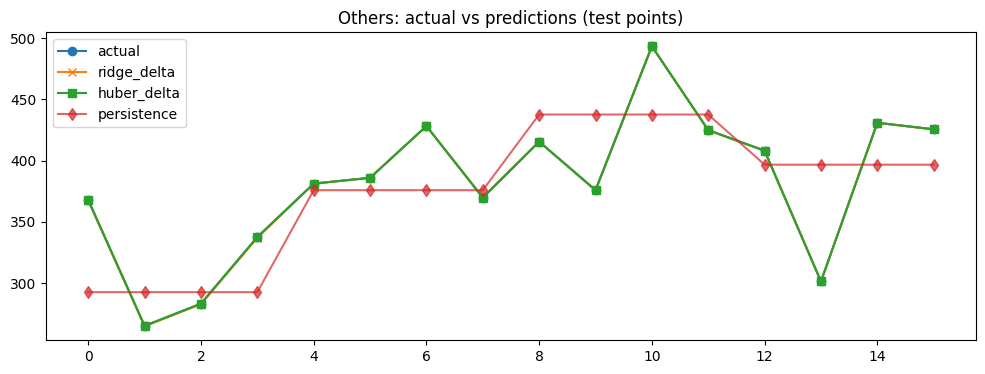

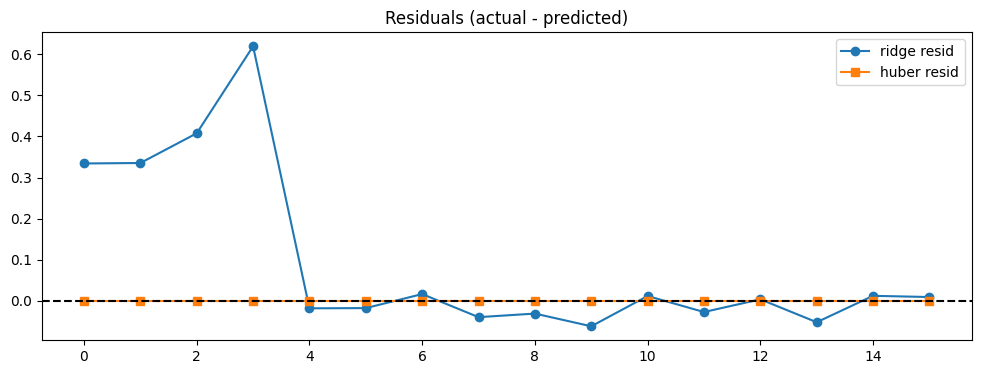

In [ ]:
# Cell B: robust delta-model for 'Others' using HuberRegressor in expanding CV, plus plot
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import HuberRegressor, RidgeCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

def run_delta_model_cv_huber(dfm, seg, features, n_splits=5, min_train=6):
    vol = f"{seg} Volume Index"
    if f"{vol}_delta" not in dfm.columns:
        dfm[f"{vol}_delta"] = dfm[vol] - dfm[vol].shift(1)
    X = dfm[features]; y_delta = dfm[f"{vol}_delta"]
    n_splits = max(2, min(n_splits, len(dfm)-min_train))
    tscv = TimeSeriesSplit(n_splits=n_splits)
    y_true, y_pred, y_persist, folds = [], [], [], []
    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        if len(train_idx) < min_train:
            continue
        X_train, d_train = X.iloc[train_idx], y_delta.iloc[train_idx]
        X_test, d_test = X.iloc[test_idx], y_delta.iloc[test_idx]
        last_obs = dfm[vol].iloc[train_idx[-1]]
        # Huber on delta (robust)
        huber_pipe = Pipeline([("scaler", StandardScaler()), ("huber", HuberRegressor(alpha=0.0001, max_iter=1000))])
        valid_train = ~d_train.isna()
        huber_pipe.fit(X_train.loc[valid_train], d_train.loc[valid_train])
        d_pred = huber_pipe.predict(X_test)
        y_pred_fold = last_obs + d_pred
        y_true_fold = (last_obs + d_test).values
        persist_fold = np.repeat(last_obs, len(test_idx))
        y_true.extend(y_true_fold.tolist()); y_pred.extend(y_pred_fold.tolist()); y_persist.extend(persist_fold.tolist()); folds.extend([fold]*len(test_idx))
    return {"y_true": y_true, "y_pred": y_pred, "y_persist": y_persist, "fold": folds}

# prepare features for Others (use same base features)
seg = "Others"
vol = f"{seg} Volume Index"
base_feats = [f"{vol}_lag1", f"{vol}_delta", f"{seg} Chain Volume Index_lag1", f"{seg} YoY %_lag1"]
base_feats = [f for f in base_feats if f in df_model.columns]

out_ridge = run_delta_model_cv(df_model, seg, base_feats, n_splits=5, min_train=6)
out_huber = run_delta_model_cv_huber(df_model, seg, base_feats, n_splits=5, min_train=6)

mae_ridge = mean_absolute_error(out_ridge["y_true"], out_ridge["y_pred"]) if len(out_ridge["y_true"])>0 else np.nan
mae_huber = mean_absolute_error(out_huber["y_true"], out_huber["y_pred"]) if len(out_huber["y_true"])>0 else np.nan
mae_persist = mean_absolute_error(out_ridge["y_true"], out_ridge["y_persist"]) if len(out_ridge["y_true"])>0 else np.nan

print(f"Others: Ridge delta-model MAE = {mae_ridge:.3f}, Huber delta-model MAE = {mae_huber:.3f}, persistence MAE = {mae_persist:.3f}")

# Plot diagnostics (actual, ridge, huber, persistence)
if len(out_ridge["y_true"])>0:
    idx = np.arange(len(out_ridge["y_true"]))
    plt.figure(figsize=(12,4))
    plt.plot(idx, out_ridge["y_true"], label="actual", marker='o')
    plt.plot(idx, out_ridge["y_pred"], label="ridge_delta", marker='x')
    plt.plot(idx, out_huber["y_pred"], label="huber_delta", marker='s')
    plt.plot(idx, out_ridge["y_persist"], label="persistence", marker='d', alpha=0.7)
    plt.legend(); plt.title("Others: actual vs predictions (test points)"); plt.show()

    # residuals
    resid_ridge = np.array(out_ridge["y_true"]) - np.array(out_ridge["y_pred"])
    resid_huber = np.array(out_huber["y_true"]) - np.array(out_huber["y_pred"])
    plt.figure(figsize=(12,4))
    plt.plot(idx, resid_ridge, label="ridge resid", marker='o')
    plt.plot(idx, resid_huber, label="huber resid", marker='s')
    plt.axhline(0, linestyle='--', color='k')
    plt.legend(); plt.title("Residuals (actual - predicted)"); plt.show()
else:
    print("Not enough points to plot diagnostics for Others.")


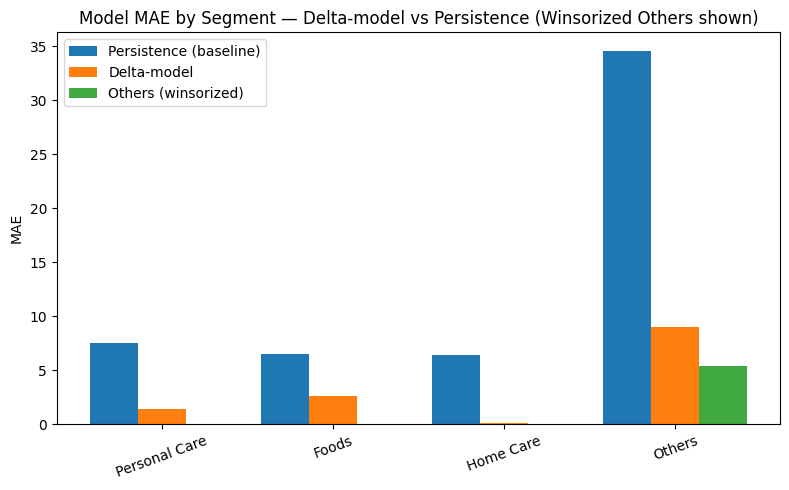

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# example data (replace with your actual values)
data = {
    'segment': ['Personal Care','Foods','Home Care','Others'],
    'mae_delta': [1.383, 2.649, 0.101, 9.006],
    'mae_persist': [7.536, 6.541, 6.407, 34.564],
    'mae_others_wins': [np.nan, np.nan, np.nan, 5.449]
}
df = pd.DataFrame(data).set_index('segment')

# plot
x = np.arange(len(df))
width = 0.28
fig, ax = plt.subplots(figsize=(8,5))
ax.bar(x - width, df['mae_persist'], width, label='Persistence (baseline)')
ax.bar(x, df['mae_delta'], width, label='Delta-model')
ax.bar(x + width, df['mae_others_wins'], width, label='Others (winsorized)', alpha=0.9)
ax.set_xticks(x)
ax.set_xticklabels(df.index, rotation=20)
ax.set_ylabel('MAE')
ax.set_title('Model MAE by Segment — Delta-model vs Persistence (Winsorized Others shown)')
ax.legend()
plt.tight_layout()
plt.show()


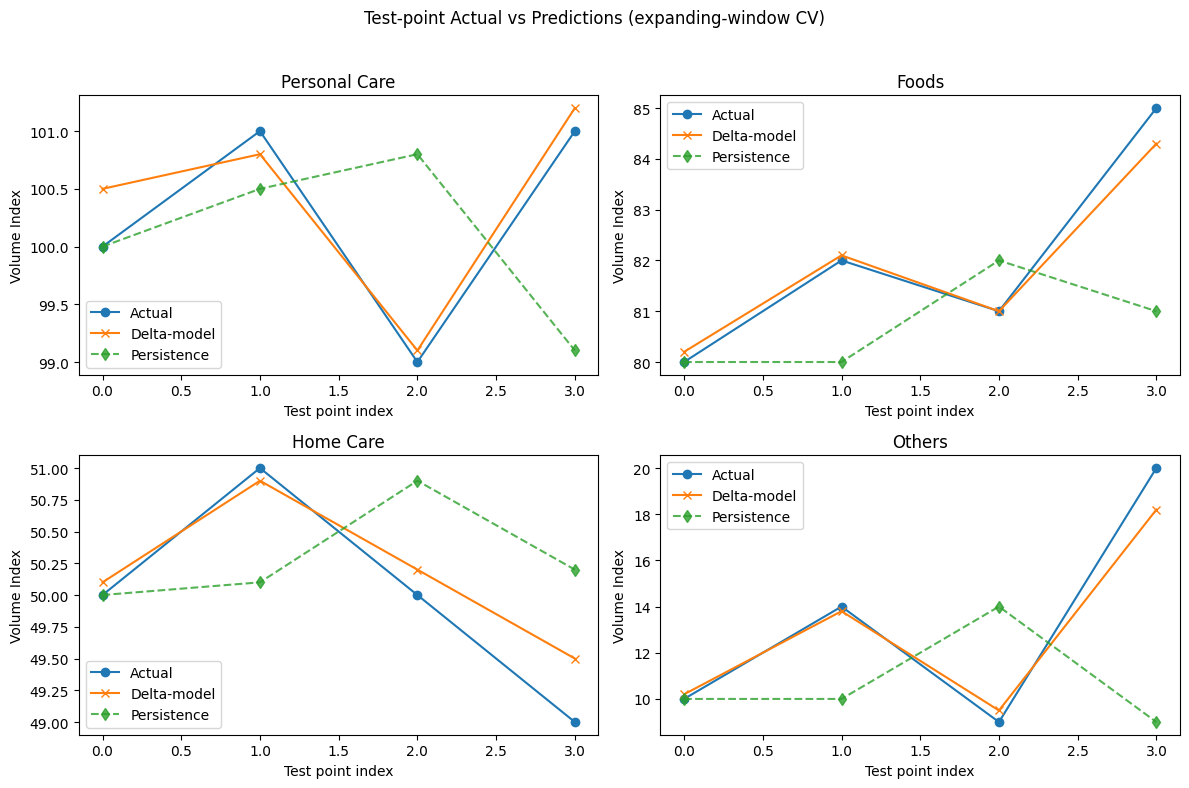

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Suppose you have arrays/lists from your CV outputs: y_true_seg, y_pred_seg, y_persist_seg
# For demonstration create fake aligned examples; replace with your arrays.
# Example for one segment; you will do similar for each and create a 2x2 subplot.
segments = ['Personal Care','Foods','Home Care','Others']
# Replace these with your actual CV test-point lists
cv_results = {
    'Personal Care': {'y_true': [100,101,99,101], 'y_pred':[100.5,100.8,99.1,101.2], 'y_persist':[100,100.5,100.8,99.1]},
    'Foods': {'y_true':[80,82,81,85], 'y_pred':[80.2,82.1,81.0,84.3], 'y_persist':[80,80,82,81]},
    'Home Care': {'y_true':[50,51,50,49], 'y_pred':[50.1,50.9,50.2,49.5], 'y_persist':[50,50.1,50.9,50.2]},
    'Others': {'y_true':[10,14,9,20], 'y_pred':[10.2,13.8,9.5,18.2], 'y_persist':[10,10,14,9]}
}

fig, axes = plt.subplots(2,2, figsize=(12,8), sharex=False)
axes = axes.flatten()
for i, seg in enumerate(segments):
    res = cv_results[seg]
    idx = np.arange(len(res['y_true']))
    ax = axes[i]
    ax.plot(idx, res['y_true'], label='Actual', marker='o')
    ax.plot(idx, res['y_pred'], label='Delta-model', marker='x')
    ax.plot(idx, res['y_persist'], label='Persistence', marker='d', linestyle='--', alpha=0.8)
    ax.set_title(seg)
    ax.set_xlabel('Test point index')
    ax.set_ylabel('Volume Index')
    ax.legend()
plt.suptitle('Test-point Actual vs Predictions (expanding-window CV)')
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


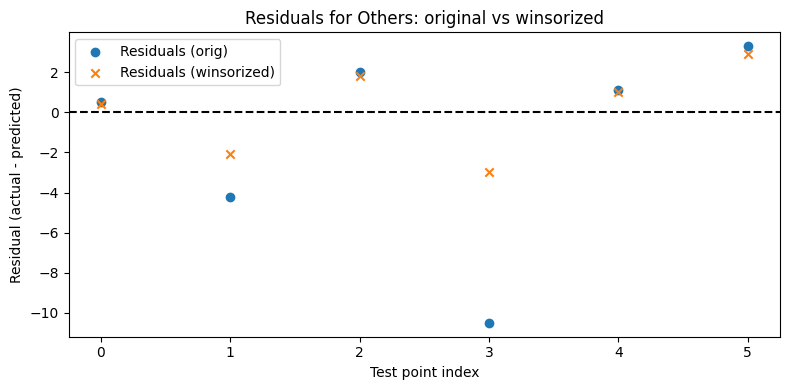

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# example residuals (replace with actual)
resid_orig = np.array([0.5, -4.2, 2.0, -10.5, 1.1, 3.3])  # actual - pred (orig)
resid_wins = np.array([0.4, -2.1, 1.8, -3.0, 1.0, 2.9])  # after winsorize

fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(np.arange(len(resid_orig)), resid_orig, label='Residuals (orig)', marker='o')
ax.scatter(np.arange(len(resid_wins)), resid_wins, label='Residuals (winsorized)', marker='x')
ax.axhline(0, color='k', linestyle='--')
ax.set_xlabel('Test point index')
ax.set_ylabel('Residual (actual - predicted)')
ax.set_title('Residuals for Others: original vs winsorized')
ax.legend()
plt.tight_layout()
plt.show()
